# Fetal Health Classifier
Using data extracted from Cardiotocogram exams, assess fetal health into one of three categories: normal, suspect, and pathological.

## Data Preprocessing

In [1]:
import pandas as pd

df = pd.read_csv('fetal_health.csv')
df.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

In [3]:
# Check for missing values
print(df.isnull().sum())

baseline value                                            0
accelerations                                             0
fetal_movement                                            0
uterine_contractions                                      0
light_decelerations                                       0
severe_decelerations                                      0
prolongued_decelerations                                  0
abnormal_short_term_variability                           0
mean_value_of_short_term_variability                      0
percentage_of_time_with_abnormal_long_term_variability    0
mean_value_of_long_term_variability                       0
histogram_width                                           0
histogram_min                                             0
histogram_max                                             0
histogram_number_of_peaks                                 0
histogram_number_of_zeroes                                0
histogram_mode                          

In [4]:
# Drop any duplicates
print(df.shape)
df.drop_duplicates(inplace=True)
print(df.shape)

(2126, 22)
(2113, 22)


In [5]:
# Check for class imbalances
df['fetal_health'].value_counts(normalize=True)
# In this dataset, 1 = Normal, 2 = Suspect, and 3 = Pathological
# This dataset is imbalanced, meaning that Precision, Recall, and F1 Score are better evaluation metrics
# Furthermore, baseline model accuracy should be at least 77.8% (if it guessed all samples as normal)

fetal_health
1.0    0.778987
2.0    0.138192
3.0    0.082821
Name: proportion, dtype: float64

In [6]:
# Creating dataset splits 
X = df.drop(['fetal_health'], axis=1)
y = df['fetal_health']

from sklearn.model_selection import train_test_split

# Split using stratified sampling to address the class imbalance, and ensure that all classes are represented in training
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

### Baseline Weak Learner 
To show the effectiveness of Advanced Ensemble Learning techniques, I will train a baseline decision tree as a weak learner to compare its effectiveness when used alone vs. aggregated.

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

baseline = DecisionTreeClassifier(max_depth=1, random_state=42) # weak learners are not deep trees
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

baseline_scores = cross_val_score(baseline, X_train, y_train, cv=cv, scoring='f1_macro') # use F1-score to address class imbalance
print("Baseline Weak Learner F1-Score: ", baseline_scores.mean())

Baseline Weak Learner F1-Score:  0.5067260818533014


## Choosing a Boosting Algorithm

Scikit-Learn features various algorithms to implement boosting. In this step, I will compare the predictive power of the following algorithms: AdaBoostClassifier, GradientBoostingClassifier, and HistGradientBoostingClassifier.

These will use similar hyperparameters so that the best base model can be chose for tuning.

In [8]:
# Finding the most effective Boosting Algorithm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

ada = AdaBoostClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
hgb = HistGradientBoostingClassifier(max_iter=100, learning_rate=0.1, max_depth=3, random_state=42)

In [9]:
# Comparing baseline models
models = [('AdaBoost', ada), ('GradBoost',gb), ('HistGradBoost',hgb)]

# Get a baseline F1-score for each model to decide which one to tune
for name, model in models:
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1_macro')
    # using F1-score to train the model to address the class imbalance
    print(name, scores.mean())

AdaBoost 0.530058244438172
GradBoost 0.8825948336491527
HistGradBoost 0.8958172778343068


As seen by the F1-scores, all ensemble learning algorithms outperform a single weak learner, demonstrating its effectiveness in classification.

AdaBoost did significantly worse compared to both GradientBoosting Algorithms. HistGradientBoosting performed slightly better than the base GradientBoosting algorith, and so I will be tuning this model to optimize performance.

## Hyperparameter Tuning the HistGradientBoostingClassifier 

By using RandomSearchCV, the optimal hyperparameters of the algorithm can be found to maximize performance. Furthermore, using random search has more efficiency benefits over hyperparameter tuning methods like grid search.

In [10]:
# First, I will define a confusion matrix plotting function
# This will help with interpretable visualizations to evalute the model
import matplotlib.pyplot as plt
import seaborn as sns

# Input arg: sklearn confusion matrix
def visualize_cm(cm):
    fig = plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Normal", "Suspect", "Pathological"],
                yticklabels=["Normal", "Suspect", "Pathological"])
    plt.title("Confusion Matrix for Fetal Health")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    return fig

F1-Score:  0.9206142575373345
              precision    recall  f1-score   support

         1.0       0.95      0.99      0.97       330
         2.0       0.98      0.71      0.82        58
         3.0       0.97      0.97      0.97        35

    accuracy                           0.95       423
   macro avg       0.97      0.89      0.92       423
weighted avg       0.95      0.95      0.95       423



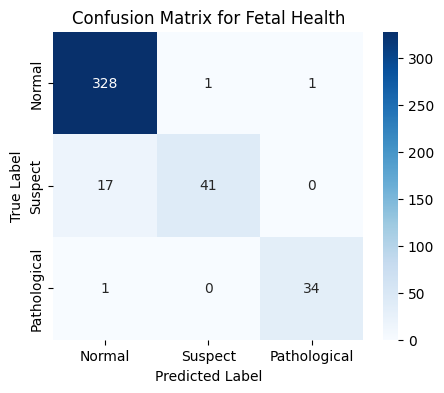

In [11]:
# Confusion Matrix for Base Model
from sklearn.metrics import confusion_matrix, classification_report, f1_score
hgb.fit(X_train, y_train)
base_hgb_preds = hgb.predict(X_test)
print("F1-Score: ", f1_score(y_test, base_hgb_preds, average='macro'))
print(classification_report(y_test, base_hgb_preds))
base_hgb_cm = visualize_cm(confusion_matrix(y_test, base_hgb_preds))

In [12]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, loguniform


# Set up parameter disitribution
param_dist = {
    "max_depth": randint(2, 8),
    "learning_rate": loguniform(0.001, 0.1),
    "max_iter": randint(50, 200),
    "min_samples_leaf": randint(10, 60),
    "l2_regularization": loguniform(0.001, 3)}

# Initialize base model + random search objects
model = HistGradientBoostingClassifier(random_state=42)
random_search = RandomizedSearchCV(
    estimator=model, param_distributions=param_dist,
    n_iter=100, scoring='f1_macro', cv=cv, n_jobs=-1,
    random_state=42, verbose=1)

# Find the best model
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
print("Chosen Parameters: ", random_search.best_params_)
print("Highest CV Score: ", random_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Chosen Parameters:  {'l2_regularization': np.float64(0.0070531249052700465), 'learning_rate': np.float64(0.0883122824824253), 'max_depth': 6, 'max_iter': 100, 'min_samples_leaf': 17}
Highest CV Score:  0.8937694817376727


F1-Score:  0.9407814407814407
              precision    recall  f1-score   support

         1.0       0.96      0.99      0.98       330
         2.0       0.96      0.76      0.85        58
         3.0       1.00      1.00      1.00        35

    accuracy                           0.96       423
   macro avg       0.97      0.92      0.94       423
weighted avg       0.96      0.96      0.96       423



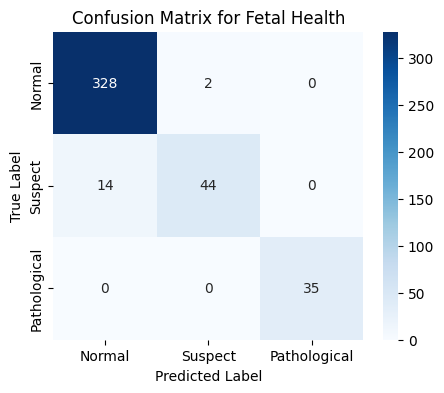

In [13]:
preds = best_model.predict(X_test)
print("F1-Score: ", f1_score(y_test, preds, average='macro'))
print(classification_report(y_test, preds))
best_model_cm = visualize_cm(confusion_matrix(y_test, preds))

Comparing baseline model parameters against the trained model parameters:

In [14]:
hgb

,loss,'log_loss'
,learning_rate,0.1
,max_iter,100
,max_leaf_nodes,31
,max_depth,3
,min_samples_leaf,20
,l2_regularization,0.0
,max_features,1.0
,max_bins,255
,categorical_features,'from_dtype'
,monotonic_cst,None


In [15]:
best_model

,loss,'log_loss'
,learning_rate,np.float64(0.0883122824824253)
,max_iter,100
,max_leaf_nodes,31
,max_depth,6
,min_samples_leaf,17
,l2_regularization,np.float64(0....1249052700465)
,max_features,1.0
,max_bins,255
,categorical_features,'from_dtype'
,monotonic_cst,None
